In [3]:
# https://www.kaggle.com/lodetomasi1995/income-classification
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
import pydotplus
from io import StringIO
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint as pp
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

import time, os
from sklearn.preprocessing import LabelEncoder

In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
np.random.seed(0)
df = pd.read_csv("../../Data/income_evaluation.csv")
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df = df.dropna()
df = df.ffill()
df = df.bfill()
df.columns = list(map(lambda x: x.strip(), df.columns))

In [6]:
price_range = df[['income']].to_numpy()
price_range[price_range=="<=50K"] = 0
price_range[price_range==">50K"] = 1
df['income'] = pd.DataFrame(price_range, columns=['income'])
y_new = pd.DataFrame(price_range, columns=['income'])
df[['income']].value_counts()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
# Do a one-hot encoding of string features - otherwise the predict method will fail
for i in df.columns:
    if i in ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']:
        df[i] = LabelEncoder().fit_transform(df[i])

In [8]:
X = df.drop(columns=['income', 'fnlwgt', 'education-num', 'relationship', 'capital-gain', 'capital-loss'])
y = y_new
y=y.astype('int')
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
df[['income']].value_counts()

income
0         24720
1          7841
dtype: int64

In [9]:
# preventing information about the distribution of the test set leaking into your model
# standard_scaler = MinMaxScaler()
# x_train_scaled = standard_scaler.fit_transform(x_train)
# x_test_scaled = standard_scaler.fit_transform(x_test)
# y_train_scaled = standard_scaler.fit_transform(y_train).astype('int')
# y_test_scaled = standard_scaler.fit_transform(y_test).astype('int')

x_train_scaled = x_train
x_test_scaled = x_test
y_train_scaled = y_train
y_test_scaled = y_test

In [10]:
clf = AdaBoostClassifier(random_state=0, base_estimator=DecisionTreeClassifier(random_state=1, max_depth=1))
start_time = time.time()
clf.fit(x_train_scaled, y_train_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred = clf.predict(x_test_scaled)
print(f"KNN Normal Model: Fit Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred)}")
print(classification_report(y_test_scaled, y_pred))

KNN Normal Model: Fit Time: 0.3971436023712158
KNN Normal Model: Fit Time: 0.030681133270263672
Score of Model Tree are (Mean Accuracy of test and train data): 0.8314140948871488
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4945
           1       0.68      0.56      0.61      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.74      0.75      6513
weighted avg       0.82      0.83      0.83      6513



In [36]:
d = df.shape[1]
depth_range = np.arange(0, 2, 0.1)
depth_range = np.arange(1, 200, 10)
param = "n_estimators"
classifier = "AdaBoost"
train_scores, test_scores = validation_curve(clf, x_train, y_train, param_name=param, param_range=depth_range, cv=5, n_jobs=-1)

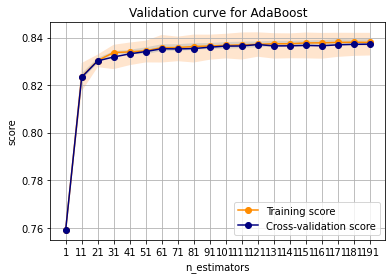

In [40]:
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
depth_range_list = depth_range
plt.figure()
plt.xticks(np.arange(1, 200, 10))
plt.plot(depth_range_list, mean_train_scores, 'o-', color="darkorange", label='Training score')
plt.fill_between(depth_range_list, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(depth_range_list, mean_test_scores, 'o-', color="navy", label='Cross-validation score')
plt.fill_between(depth_range_list, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title(f'Validation curve for {classifier}')
plt.xlabel(param)
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/ada_validation_curve_income.png')
plt.show()

In [39]:
### PIPELINES ###
# Data scaled in pipeline already
pipeline = make_pipeline(SelectFromModel(RandomForestClassifier(random_state=0)), AdaBoostClassifier(random_state=0))
pipeline.fit(x_train_scaled, y_train_scaled)
print(f"MLP Pipeline Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline = pipeline.predict(x_test_scaled)
print(f"MLP Pipeline Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline)}")
print(classification_report(y_test_scaled, y_pred_pipeline))

MLP Pipeline Model: Fit Time: 6.742261648178101
MLP Pipeline Model: Predict Time: 0.054398298263549805
Score of Model Tree are (Mean Accuracy of test and train data): 0.8327959465684016
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      4945
           1       0.69      0.55      0.61      1568

    accuracy                           0.83      6513
   macro avg       0.78      0.74      0.75      6513
weighted avg       0.82      0.83      0.83      6513



In [41]:
### TUNING ####
d = x_train.shape[1]
param = {'adaboostclassifier__learning_rate': np.arange(0.0, 1.0, 0.1),
         'adaboostclassifier__algorithm': ['SAMME'],
         'adaboostclassifier__n_estimators': np.arange(1, 200),
         'adaboostclassifier__base_estimator': [DecisionTreeClassifier(random_state=0, max_depth=1)]
        }
clf_cv = GridSearchCV(pipeline, n_jobs=-1, param_grid=param, refit=True, cv=5, return_train_score=True, verbose=1)
start_time = time.time()
clf_cv = clf_cv.fit(x_train_scaled, np.ravel(y_train_scaled))
print(f"MLP CV Model: Fit Time: {time.time() - start_time}")
start_time = time.time()
y_pred_pipeline_cv = clf_cv.predict(x_test_scaled)
print(f"MLP CV Model: Predict Time: {time.time() - start_time}")
print(f"Score of Model Tree are (Mean Accuracy of test and train data): {accuracy_score(y_test_scaled, y_pred_pipeline_cv)}")
print(classification_report(np.ravel(y_test_scaled), y_pred_pipeline_cv))

Fitting 5 folds for each of 1990 candidates, totalling 9950 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 608 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1058 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 2258 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3008 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3858 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4808 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5858 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 7008 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 8258 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 9608 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 9950 out of 9950 | elapsed:  5.2min finished


MLP CV Model: Fit Time: 312.64236855506897
MLP CV Model: Predict Time: 0.05526590347290039
Score of Model Tree are (Mean Accuracy of test and train data): 0.828036235221864
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4945
           1       0.69      0.52      0.59      1568

    accuracy                           0.83      6513
   macro avg       0.77      0.72      0.74      6513
weighted avg       0.82      0.83      0.82      6513



In [42]:
clf_cv.best_params_

{'adaboostclassifier__algorithm': 'SAMME',
 'adaboostclassifier__base_estimator': DecisionTreeClassifier(max_depth=1, random_state=0),
 'adaboostclassifier__learning_rate': 0.9,
 'adaboostclassifier__n_estimators': 141}

In [43]:
### Learning Curve ###
train_sizes = np.arange(0.1, 1.0, 0.1)
clf_new = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0, max_depth=1), 
                             n_estimators=141, learning_rate=0.9, algorithm="SAMME")
_, train_scores, test_scores = learning_curve(clf_new, x_train, np.ravel(y_train), train_sizes=train_sizes, cv=5)

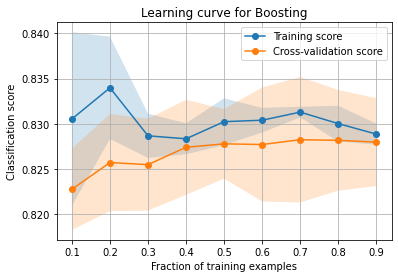

In [44]:
plt.figure()
mean_train_scores = np.mean(train_scores, axis=1)
std_train_scores = np.std(train_scores, axis=1)
mean_test_scores = np.mean(test_scores, axis=1)
std_test_scores = np.std(test_scores, axis=1)
plt.plot(train_sizes, mean_train_scores, 'o-', label='Training score')
plt.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, alpha=0.2)
plt.plot(train_sizes, mean_test_scores, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, mean_test_scores - std_test_scores, mean_test_scores + std_test_scores, alpha=0.2)
plt.title('Learning curve for Boosting')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.savefig(os.getcwd() + '/boosting_learning_curve_income.png')
plt.show()

In [11]:
lw = 2
params = np.arange(1, 250, 10)
# params = np.arange(0.1, 2.0, 0.2)
clf_score_list = []
fit_time_list = []
predict_time_list = []
main_start_time = time.time()
for i in params:
    print(f"Iteration: {i}")
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0, max_depth=1), n_estimators=i, learning_rate=0.9)
    start_time = time.time()
    clf.fit(x_train_scaled, y_train_scaled)
    clf_score_list.append(clf.score(x_test_scaled, y_test_scaled))
    
    end_time = time.time() - start_time
    fit_time_list.append(end_time)
    
    start_time = time.time()
    y_pred = clf.predict(x_test_scaled)
    end_time = time.time() - start_time
    predict_time_list.append(end_time)
    
print(f"Entire cell took {time.time() - main_start_time}")

Iteration: 1
Iteration: 11
Iteration: 21
Iteration: 31
Iteration: 41
Iteration: 51
Iteration: 61
Iteration: 71
Iteration: 81
Iteration: 91
Iteration: 101
Iteration: 111
Iteration: 121
Iteration: 131
Iteration: 141
Iteration: 151
Iteration: 161
Iteration: 171
Iteration: 181
Iteration: 191
Iteration: 201
Iteration: 211
Iteration: 221
Iteration: 231
Iteration: 241
Entire cell took 27.019009113311768


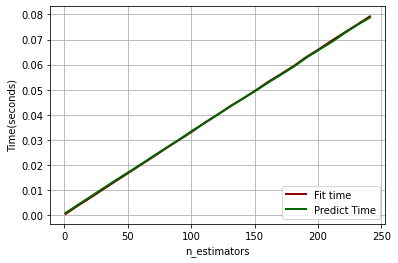

In [13]:
def normalize_data_points(points):
    return [float(i)/sum(points) for i in points]

lw = 2
param_list = params
plt.plot(param_list, normalize_data_points(fit_time_list), label="Fit time", color="darkred", lw=lw)
plt.plot(param_list, normalize_data_points(predict_time_list), label="Predict Time", color="darkgreen", lw=lw)

plt.xlabel('n_estimators')
plt.ylabel("Time(seconds)")
# plt.xticks(np.arange(1, len(param_list), 2.0))
# plt.yticks(np.arange(min(predict_time_list), max(fit_time_list), 0.004))
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/boosting_fit_vs_prediction_income.png')


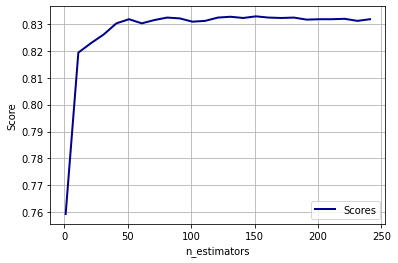

In [53]:
w = 2
plt.plot(param_list, clf_score_list, label="Scores", color="darkblue", lw=lw)
plt.xlabel('n_estimators')
plt.ylabel("Score")
plt.grid()
plt.legend(loc='lower right')
plt.savefig(os.getcwd() + '/boosting_n_estimators_vs_score_income.png')
